# authorship attribution
## by: Dekel Mor, Matan Ramati


### Introduction and motivation

We live in changing times: With the way our social media activity increases, we now have a shift away from traditional communication towards a text-based one, and that made facial recognition and voice recognition irrelevant. While these type of messages may have significant advantages and allows us to persist in a globalized world, some question and problem arise we have to face. Undoubtfully, one crucial ability is the identification of an author through its texts; without direct contact, fakes are elsewhere hardly recognizable. The science of identifying authors by there writing is called Stylometry. With our ability to access big data and having sufficient computational power nowadays, the accuracy we may gain in such kinds of tasks is quite impressive.

### the data

our required data is a collection of pairs that contains rich text(not formally, because we want to find differences) and the text author identification.
because we wand to classify the text by his author.

we chose to use blog posts data set contain 681,288 posts of 19,320 bloggers  (more details about the dataset in the link) :
https://www.kaggle.com/rtatman/blog-authorship-corpus

### project outlines

1) Extract the data to a simple CSV form (readable to Pandas library). and start cleaning the data. the dataset has irrelevant columns (as: author gender, age, etc'), so we will drop them. secondly due to the large quantity of data(681,288 posts of 19,320 bloggers) we will choose a few authors to focus on(probably the authors with the largest quantity of posts).

2) Preliminary analysis, including visualizing some of the data in many forms, in order to consider the next steps and maybe adjust the project outlines. we will try to find text features, analyze them, visualize them and analyze how much they contribute to find a difference between authors.

3) Divide the information into two groups in order to use cross-validation. Apparently, 80% for trainings set and 20% for test set (maybe we will do some meta-learning here - learn the best partition) Training many simple models on the data, such as MultinomialNB, LogisticRegression, NaiveBayesClassifier and more.

4) Conclusions.


### Data analysis

In [1]:
# all the imports

import sys
import nltk
import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sns
import sklearn as skl
from nltk.corpus import stopwords
from random import shuffle
from nltk import FreqDist
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from nltk import NaiveBayesClassifier
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
# read the blogtext file to data frame table
dataset = pd.read_csv('blogtext.csv', delimiter=',', nrows=50000)
# drop the irrelevant columns
dataset = dataset.drop(['date', 'sign', 'topic', 'age', 'gender'], axis = 1)
dataset.head()

,id,text
0,2059027,"Info has been found (+/- 100 pages,..."
1,2059027,These are the team members: Drewe...
2,2059027,In het kader van kernfusie op aarde...
3,2059027,testing!!! testing!!!
4,3581210,Thanks to Yahoo!'s Toolbar I can ...


#### find the 20 authors with the largest amount of posts(because we want us to have many posts from each author to train the model on it)

In [3]:
dataset['id'].value_counts()[:20]

589736     2294
883178     1616
988941     1542
546850      931
1713442     798
888601      778
3211137     630
2821801     605
1103575     558
766556      532
1926378     473
727002      472
1538911     447
152151      436
1939766     407
1098541     339
299143      328
3581446     315
480727      312
3169212     309
Name: id, dtype: int64

#### drop the posts that doesnt belong to the 20 top authors(by amount of posts) and show the number of posts per author

number of posts:  14122


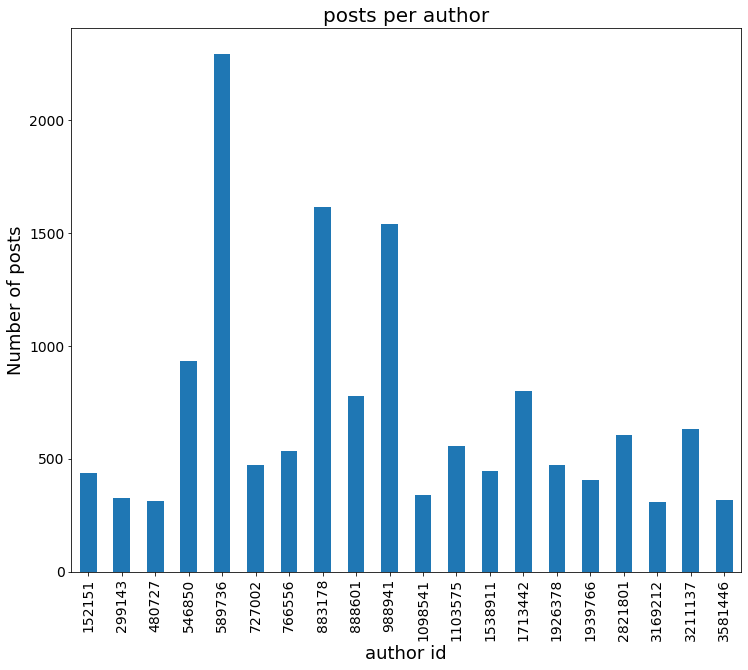

In [4]:
# keep only the rows of the top 20 authors(by number of posts)
top_authors = dataset['id'].value_counts()[:20].index.tolist()

# drop the rows that doesnt belong to authors who in the top 10 list
dataset = dataset[dataset['id'].isin(top_authors)]

dataset.reset_index(drop=True, inplace=True)

text_group = dataset.groupby('id')
ax=text_group['id'].aggregate(len).plot(kind='bar', fontsize=14, figsize=(12,10))
ax.set_title('posts per author', fontsize=20)
ax.set_ylabel('Number of posts', fontsize=18)
ax.set_xlabel('author id', fontsize=18)

print("number of posts: ",len(dataset))

as we see, most of the authors we selected have balance amount of post.


#### drop the posts with text lentgh of 0(no text)

In [5]:
for i in range(len(dataset)):
    if( len(dataset.loc[i].text) == 0 ):
        dataset = dataset.drop([dataset.loc[i].name])

        
dataset.reset_index(drop=True, inplace=True)

#### build another data frame to work on it.

In [ ]:
df = pd.DataFrame(columns=["id", "text"])
for i in range(len(dataset)):
    df.loc[i] = [dataset.loc[i].id, dataset.loc[i].text]

#### add relevant columns 
post_len : the length of the posts = number of char

word_count : number of words 

In [6]:
df['post_len'] = df['text'].astype(str).apply(len)
df['word_count'] = df['text'].apply(lambda x: len(str(x).split()))
df.head()

,id,text,post_len,word_count
0,589736,Much funny. 2 points. As mentioned in the...,220,39
1,589736,"Harpers, Harpers, everywhere. Harpers, Har...",373,53
2,589736,"In an earlier post, Johnathan said: 'And ...",1515,275
3,589736,"I'd post this on the RTG Blog, but I can't...",1972,343
4,589736,The answer to the first question lies with ...,154,26


#### tokenize the text: In order to use textual data for predictive modeling, the text must be parsed to remove certain words – this process is called tokenization.

In [7]:
for i in range(len(df)):
    df.loc[i] = [df.loc[i].id, 
                 nltk.word_tokenize(df.loc[i].text), 
                 df.loc[i].post_len, 
                 df.loc[i].word_count]
df.head()

,id,text,post_len,word_count
0,589736,"[Much, funny, ., 2, points, ., As, mentioned, ...",220,39
1,589736,"[Harpers, ,, Harpers, ,, everywhere, ., Harper...",373,53
2,589736,"[In, an, earlier, post, ,, Johnathan, said, :,...",1515,275
3,589736,"[I, 'd, post, this, on, the, RTG, Blog, ,, but...",1972,343
4,589736,"[The, answer, to, the, first, question, lies, ...",154,26


#### add columns of the proportion dots and  commas per word_count

the percentage of commas / dots number to the number of tokens in the post.

In [8]:
df['commas'] = '0'
df['dots'] = '0'

for i in range(len(df)):
    df.loc[i] = [df.loc[i].id, 
                 df.loc[i].text, 
                 df.loc[i].post_len, 
                 df.loc[i].word_count, 
                 df.loc[i].text.count(',')/df.loc[i].word_count, 
                 df.loc[i].text.count('.')/df.loc[i].word_count]
df.head()

C:\Users\ramat\anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in longlong_scalars
  if __name__ == '__main__':
C:\Users\ramat\anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in longlong_scalars
  # Remove the CWD from sys.path while we load stuff.


,id,text,post_len,word_count,commas,dots
0,589736,"[Much, funny, ., 2, points, ., As, mentioned, ...",220,39,0.0512821,0.102564
1,589736,"[Harpers, ,, Harpers, ,, everywhere, ., Harper...",373,53,0.339623,0.150943
2,589736,"[In, an, earlier, post, ,, Johnathan, said, :,...",1515,275,0.0581818,0.0327273
3,589736,"[I, 'd, post, this, on, the, RTG, Blog, ,, but...",1972,343,0.0641399,0.0466472
4,589736,"[The, answer, to, the, first, question, lies, ...",154,26,0.0384615,0.0384615


In [9]:
df.tail()

,id,text,post_len,word_count,commas,dots
14117,988941,"[I, 'm, dying, from, lack, of, sleep, ., Got, ...",191,35,0,0.0857143
14118,988941,"[Saw, King, Arthur, last, night, ., Thumbs, up...",303,51,0.0392157,0.117647
14119,988941,"[I, was, topless, around, 20, mins, ago, ., Ha...",179,30,0.0333333,0.133333
14120,988941,"[Well, well, I, 'm, not, topless, so, neeeeeee...",1244,223,0.0224215,0.0762332
14121,988941,"[I, am, currently, topless, ., Contreversial]",58,5,0,0.2


#### remove irelevant stop words and punctuation marks before adding textual richness and word length distrubtion features to the data frame :

In [10]:
stop_words = set(stopwords.words('english'))
stop_words.add(',')
stop_words.add('.')
stop_words.add('?')
stop_words.add('!')
stop_words.add('...')
stop_words.add(':')

In [12]:
for i in range(len(df)):
    if( len(df.loc[i].text) == 0 ):
        df = df.drop([df.loc[i].name])

        
df.reset_index(drop=True, inplace=True)

#### add columns textual richness and word length distrubtion

In [13]:
df['richness'] = '0'
df['wldist'] = '0'

for i in range(len(df)):
    df.loc[i] = [df.loc[i].id, 
                 [x for x in df.loc[i].text if x not in stop_words], 
                 df.loc[i].post_len, 
                 df.loc[i].word_count, 
                 df.loc[i].commas, 
                 df.loc[i].dots,
                (len(set(df.loc[i].text)) / len(df.loc[i].text)), 
                 FreqDist(len(w) for w in df.loc[i].text)]
df.tail()

,id,text,post_len,word_count,commas,dots,richness,wldist
14081,988941,"[I, 'm, dying, lack, sleep, Got, woken, 9:45, ...",191,35,0,0.0857143,0.871795,"{1: 8, 2: 7, 5: 8, 4: 6, 3: 4, 7: 2, 6: 4}"
14082,988941,"[Saw, King, Arthur, last, night, Thumbs, Broug...",303,51,0.0392157,0.117647,0.78125,"{3: 9, 4: 10, 6: 7, 5: 7, 1: 14, 2: 10, 7: 4, ..."
14083,988941,"[I, topless, around, 20, mins, ago, Hard, day,...",179,30,0.0333333,0.133333,0.885714,"{1: 7, 3: 8, 7: 1, 6: 3, 2: 4, 4: 7, 5: 3, 9: ..."
14084,988941,"[Well, well, I, 'm, topless, neeeeeeeeeeeeeeee...",1244,223,0.0224215,0.0762332,0.637066,"{4: 44, 1: 41, 2: 38, 3: 56, 7: 19, 21: 1, 5: ..."
14085,988941,"[I, currently, topless, Contreversial]",58,5,0,0.2,1,"{1: 2, 2: 1, 9: 1, 7: 1, 13: 1}"


#### visualize the wldist(word length distribution):

In [14]:
one = df[df['id']==589736]
two = df[df['id']==734562]

# the word length : and the Number of occurrences on the post. for example the posts of author id 589736
one.wldist

0       {4: 7, 5: 5, 1: 5, 6: 2, 2: 2, 9: 2, 8: 2, 7: ...
1            {7: 21, 10: 1, 6: 4, 4: 7, 5: 5, 1: 2, 3: 3}
2       {2: 10, 7: 13, 4: 41, 9: 6, 6: 17, 10: 7, 8: 7...
3       {1: 7, 2: 15, 4: 31, 3: 22, 5: 21, 7: 23, 6: 3...
4       {3: 1, 6: 5, 5: 2, 8: 2, 4: 2, 2: 1, 1: 1, 9: ...
                              ...                        
2283    {3: 4, 8: 1, 2: 6, 9: 1, 4: 8, 1: 7, 5: 2, 6: ...
2284    {3: 14, 8: 2, 2: 11, 4: 6, 7: 4, 5: 8, 1: 9, 6...
2285    {4: 18, 2: 17, 6: 13, 1: 22, 7: 12, 3: 26, 5: ...
2286    {4: 68, 6: 31, 1: 32, 3: 78, 2: 37, 7: 31, 5: ...
2287    {1: 51, 2: 39, 5: 38, 7: 24, 4: 41, 3: 42, 9: ...
Name: wldist, Length: 2288, dtype: object

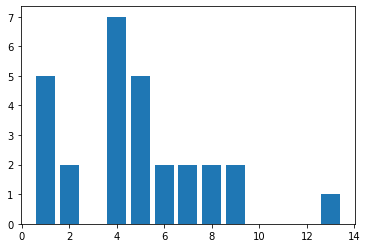

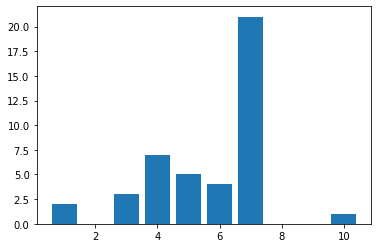

In [15]:
# the plot visualize the word length distribution of two posts. 
import matplotlib.pyplot as pltplot

fqd = df.loc[0].wldist
fqd2 = df.loc[1].wldist

pltplot.bar(*zip(*sorted(fqd.items())))
pltplot.show()

pltplot.bar(*zip(*sorted(fqd2.items())))
pltplot.show()

In [16]:
classes = df['id']
features = df.drop(['id'], axis=1)

C:\Users\ramat\anaconda3\lib\site-packages\seaborn\categorical.py:3695: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


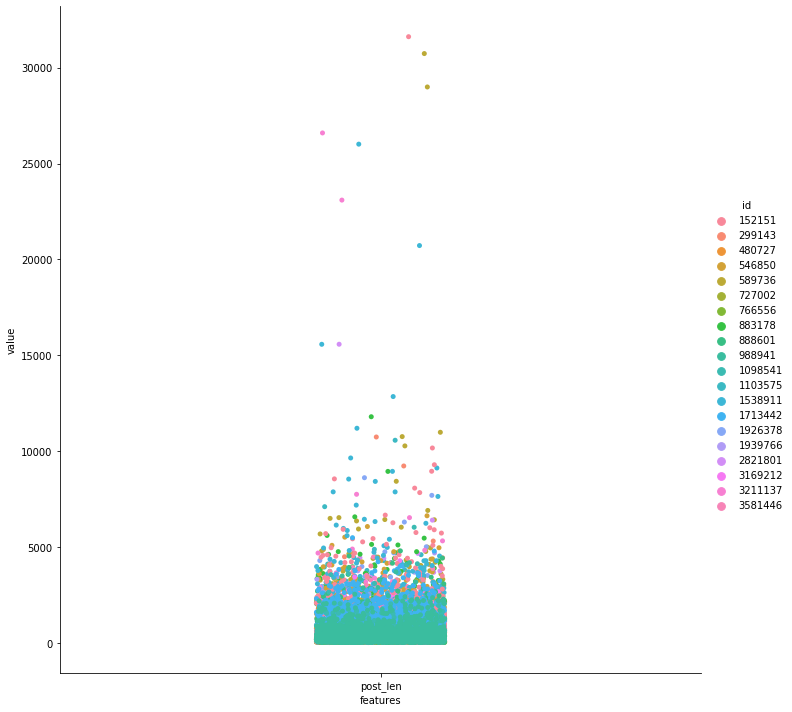

In [17]:
data = pd.concat([classes, features.iloc[:,1]], axis=1)

data = pd.melt(data, id_vars="id",
                      var_name="features",
                      value_name='value')

plt.figure.Figure(figsize=(20,20))
sns.catplot(x="features", y="value", hue="id", data=data, size=10)

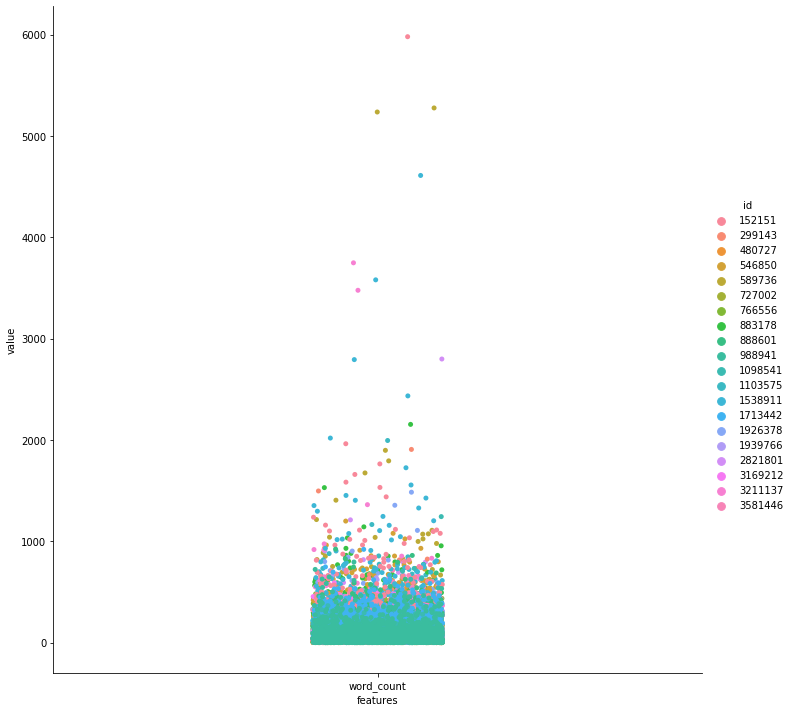

In [18]:
data = pd.concat([classes, features.iloc[:,2]], axis=1)

data = pd.melt(data, id_vars="id",
                      var_name="features",
                      value_name='value')

plt.figure.Figure(figsize=(20,20))
sns.catplot(x="features", y="value", hue="id", data=data, size=10)

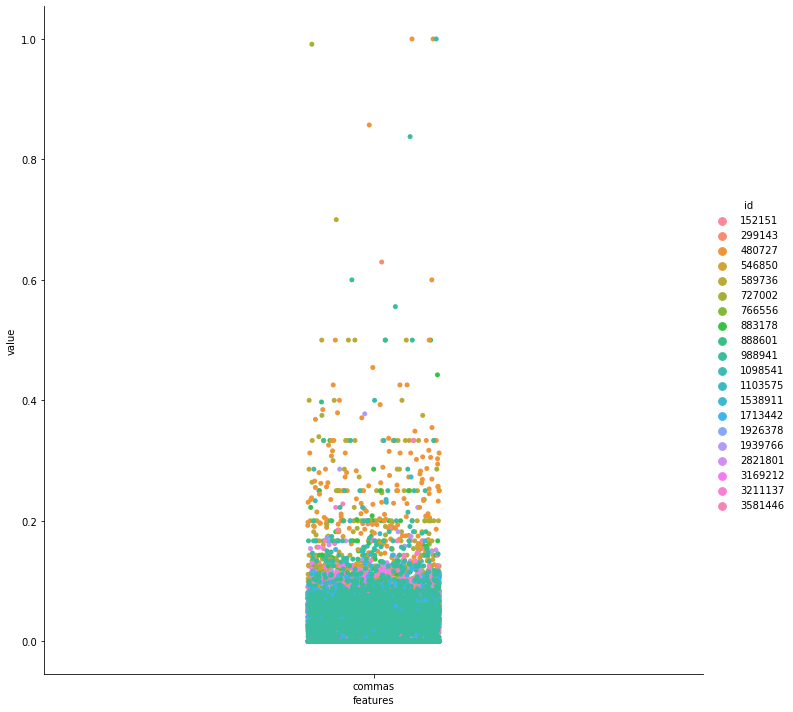

In [19]:
data = pd.concat([classes, features.iloc[:,3]], axis=1)

data = pd.melt(data, id_vars="id",
                      var_name="features",
                      value_name='value')

plt.figure.Figure(figsize=(20,20))
sns.catplot(x="features", y="value", hue="id", data=data, size=10)

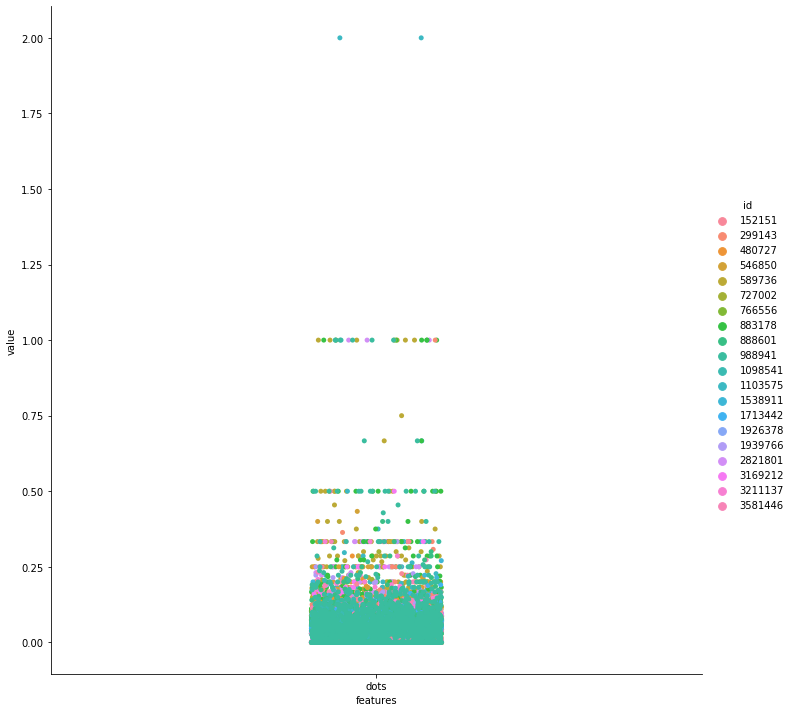

In [20]:
data = pd.concat([classes, features.iloc[:,4]], axis=1)

data = pd.melt(data, id_vars="id",
                      var_name="features",
                      value_name='value')

plt.figure.Figure(figsize=(20,20))
sns.catplot(x="features", y="value", hue="id", data=data, size=10)

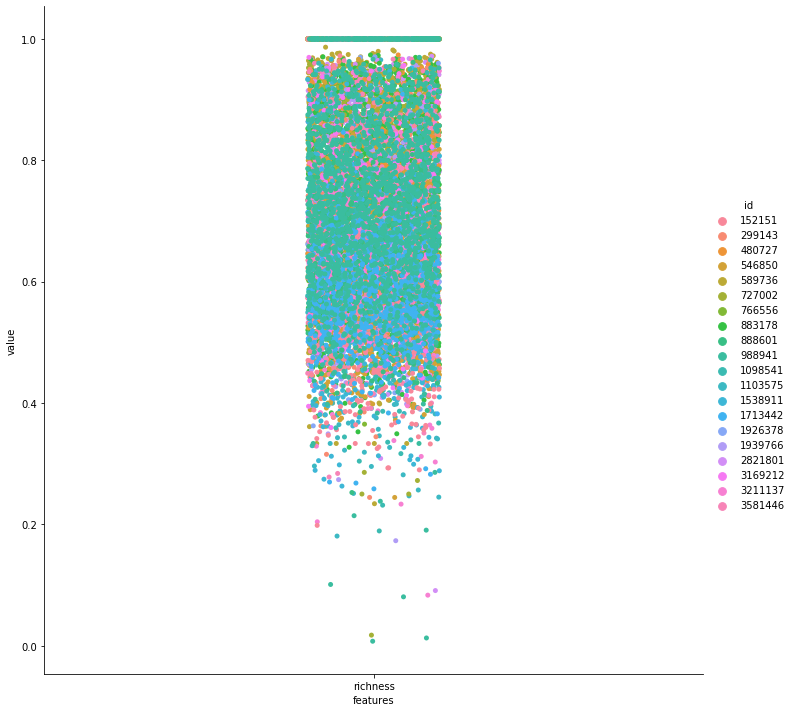

In [21]:
data = pd.concat([classes, features.iloc[:,5]], axis=1)

data = pd.melt(data, id_vars="id",
                      var_name="features",
                      value_name='value')

plt.figure.Figure(figsize=(20,20))
sns.catplot(x="features", y="value", hue="id", data=data, size=10)

### Conclusions from the data analysis:
as we saw, the difference of the features of different authors are almost not exist, they are very similar to each other.
so we cant expect for good accuracy if we try to make classification based on those features.







### Feature extraction: transforming arbitrary data, such as text , into numerical features usable for machine learning.

#### Text Analysis is a major application field for machine learning algorithms. However the raw data, a sequence of symbols cannot be fed directly to the algorithms themselves as most of them expect numerical feature vectors with a fixed size rather than the raw text documents with variable length.

#### After the tokenizion, These words need to then be encoded as integers for use as inputs in machine learning algorithms. This process is called vectorization.

#### there are few ways to vectorize the words, the two popular ways are: 
####  Count Vectorization -
The CountVectorizer provides a simple way to both tokenize a collection of text documents and build a vocabulary of known words, but also to encode new documents using that vocabulary.

An encoded vector is returned with a length of the entire vocabulary and an integer count for the number of times each word appeared in the document.

####  TFIDF -
short for term frequency–inverse document frequency, is a numerical statistic that is intended to reflect how important a word is to a document.

Word counts are a good starting point, but are very basic.

One issue with simple counts is that some words like “the” will appear many times and their large counts will not be very meaningful in the encoded vectors.

An alternative is to calculate word frequencies, and by far the most popular method is called TF-IDF. This is an acronym than stands for “Term Frequency – Inverse Document” Frequency which are the components of the resulting scores assigned to each word.

Term Frequency: This summarizes how often a given word appears within a document.
Inverse Document Frequency: This downscales words that appear a lot across documents.
Without going into the math, TF-IDF are word frequency scores that try to highlight words that are more interesting, e.g. frequent in a document but not across documents.


In [27]:
print("number of posts in our dataset: "+len(df))

NameError: name 'df' is not defined

In [23]:
Xfeatures = df['text']
ylabels = df['id']

#### CountVectorizer:

In [24]:
cv = CountVectorizer(tokenizer=lambda doc: doc, lowercase=False)
X = cv.fit_transform(Xfeatures)

In [25]:
# split the dataset to training and testing dataset, size of test set 10% of the dataset
x_train,x_test,y_train,y_test = train_test_split(X,ylabels,test_size=0.10,random_state=42)

In [26]:
x_train.shape

(12677, 85944)

In [27]:
# The multinomial Naive Bayes classifier is suitable for classification with 
# discrete features (e.g., word counts for text classification). The multinomial distribution normally 
# requires integer feature counts.
# However, in practice, fractional counts such as tf-idf may also work.

y_train = y_train.astype('int')
y_test = y_test.astype('int')
clf = MultinomialNB()
clf.fit(x_train,y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [28]:
print("Accuracy of Model :",clf.score(x_test,y_test))

Accuracy of Model : 0.6202980837473385


In [29]:
# Logistic Regression (aka logit, MaxEnt) classifier.
# In the multiclass case, the training algorithm uses the one-vs-rest (OvR) scheme if 
# the ‘multi_class’ option is set to ‘ovr’, and uses the cross-entropy loss if 
# the ‘multi_class’ option is set to ‘multinomial’. (Currently the ‘multinomial’ option is supported 
# only by the ‘lbfgs’, ‘sag’, ‘saga’ and ‘newton-cg’ solvers.)

logit = LogisticRegression(random_state=0, multi_class="auto", solver='lbfgs')
logit.fit(x_train,y_train)

C:\Users\ramat\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [30]:
print("Accuracy of Logit Model :",logit.score(x_test,y_test))

Accuracy of Logit Model : 0.7416607523066004


In [31]:
svc = LinearSVC()
svc.fit(x_train,y_train)
print("Accuracy of svc Model :",svc.score(x_test,y_test))

Accuracy of svc Model : 0.7374024130589071


C:\Users\ramat\anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


### trying TFIDF Vectorization, on smaller sample of the data from shortness of memory reasons

In [22]:
# id of the five authors and number of blog posts on the dataset
sample = dataset[5000:7000]
sample['id'].value_counts()

883178     605
1926378    473
727002     472
480727     312
299143     138
Name: id, dtype: int64

In [23]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=1, norm='l2', encoding='latin-1', ngram_range=(1, 1), stop_words='english')
features = tfidf.fit_transform(sample.text).toarray()
labels = sample.id
features.shape

(2000, 18418)

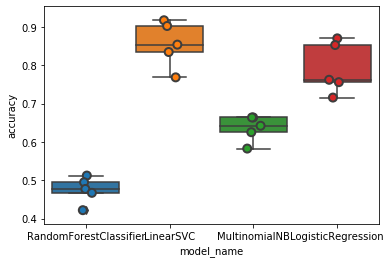

In [24]:
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0, multi_class="auto", solver='lbfgs'),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.pyplot.show()

In [25]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.855802
LogisticRegression        0.791748
MultinomialNB             0.635880
RandomForestClassifier    0.474882
Name: accuracy, dtype: float64

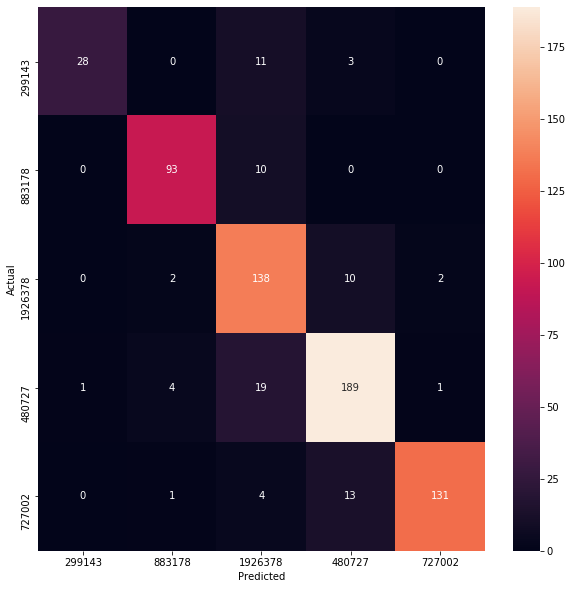

In [26]:
model = LinearSVC()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, sample.id, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.pyplot.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=set(sample.id), yticklabels=set(sample.id))
plt.pyplot.ylabel('Actual')
plt.pyplot.xlabel('Predicted')
plt.pyplot.show()

### Conclusions:

as we can see, we got pretty good accuracy with the LogisticRegression and LinearSVC Classifiers, the TFIDF Vectorization gave us better accuracy with these two.
when the best result we got from the combination of TFIDF Vectorization with LinearSVC, thats not so surprising because the TFIDF is sophisticated and less basic then the CountVectorizer.
